In [69]:
# Import libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import pickle

In [43]:
# Load data
df_train = pd.read_csv('../data/processed/df_train.csv')
df_test = pd.read_csv('../data/processed/df_test.csv')
df_val = pd.read_csv('../data/processed/df_val.csv')

df_test.sample(10)

,tpsa,sacc,h050,mlogp,rdch,gats1p,nn,c040,lc50
5,111.87,144.177,1,1.748,2.377,0.839,2,0,4.790
33,9.23,11.000,0,2.274,2.150,1.754,0,0,3.700
53,0.00,0.000,0,3.945,2.344,0.678,0,0,5.500
69,12.47,14.124,0,3.827,3.362,1.373,1,0,5.102
73,12.03,18.011,1,0.817,1.800,1.488,1,0,3.930
99,26.30,36.145,0,2.754,2.454,1.421,0,1,4.886
109,118.06,85.367,4,-0.081,1.768,1.061,0,0,3.758
63,64.16,92.470,0,3.613,4.245,1.175,4,2,4.835
28,46.53,78.828,1,2.758,2.856,1.022,0,1,3.794
80,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740


In [44]:
# Machine learning
X_train = df_train.drop(columns='lc50')
X_test = df_test.drop(columns='lc50')
X_val = df_val.drop(columns='lc50')

y_train = df_train['lc50']
y_test = df_test['lc50']
y_val = df_val['lc50']

In [45]:
rdg = Pipeline([
    ('proc', StandardScaler()),
    ('rdg', Ridge(random_state=2025))
])

knn = Pipeline([
    ('proc', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

rf = Pipeline([
    ('proc', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=2025))
])

hb = Pipeline([
    ('proc', StandardScaler()),
    ('hb', HistGradientBoostingRegressor(random_state=2025))
])

In [46]:
def metrics(y_test, y_hat):
    mse = round(mean_squared_error(y_test, y_hat), 2)
    r2 = round(r2_score(y_test, y_hat), 2)
    mae = round(mean_absolute_error(y_test, y_hat), 2)

    return mse, r2, mae

In [59]:
def display_metrics(metrics_df, name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(name, fontsize=16)

    # Plot MSE
    axes[0].bar(metrics_df.index, metrics_df['MSE'], color='b')
    axes[0].set_title('Mean Squared Error (MSE)')
    axes[0].set_ylabel('Error')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot R2
    axes[1].bar(metrics_df.index, metrics_df['R2'], color='g')
    axes[1].set_title('R2 Score')
    axes[1].set_ylabel('R2')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot MAE
    axes[2].bar(metrics_df.index, metrics_df['MAE'], color='r')
    axes[2].set_title('Mean Absolute Error (MAE)')
    axes[2].set_ylabel('Error')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [47]:
models = [
          (rdg, 'Ridge', 'rdg'),
          (knn, 'K Nearest', 'knn'),
          (rf, 'Random Forest', 'rf'),
          (hb, 'Histogram G Boosting', 'hb')
]

performance = {}

for est, name, sname in models:
    # Training
    est.fit(X_train, y_train)

    # Prediction
    y_hat = est.predict(X_val)

    # Metrics
    mse, r2, mae = metrics(y_val, y_hat)

    performance[name] = {
        'MSE': mse, 
        'R2': r2,
        'MAE': mae
    }

pd.DataFrame(performance)

,Ridge,K Nearest,Random Forest,Histogram G Boosting
MSE,2.07,1.39,0.29,0.36
R2,0.44,0.63,0.92,0.90
MAE,1.09,0.78,0.38,0.45


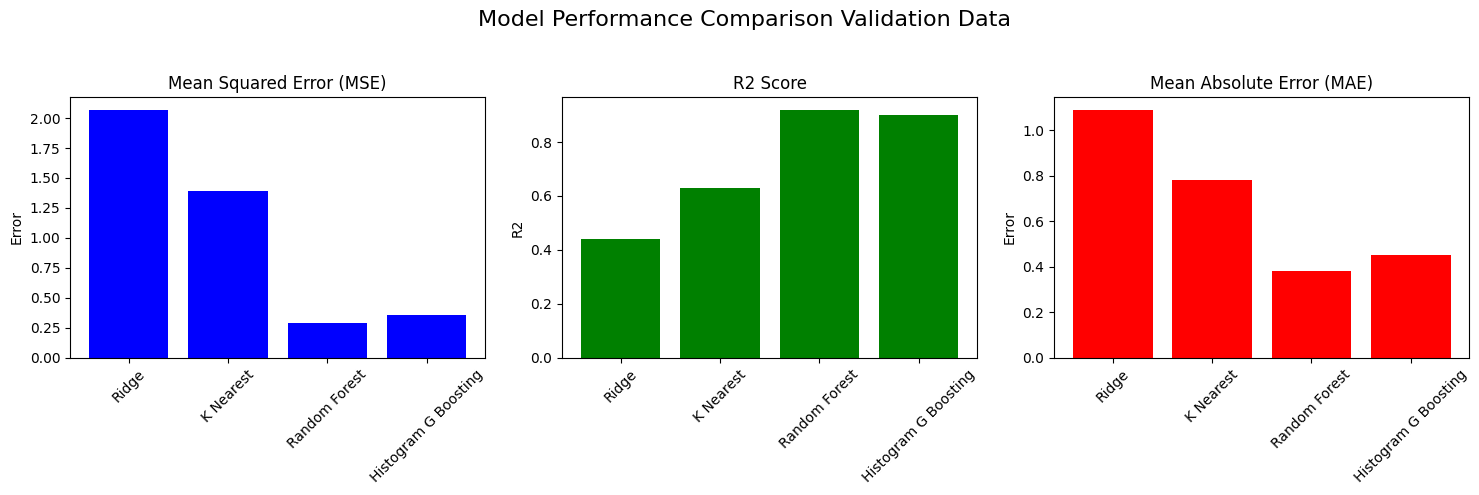

In [61]:
metrics_df = pd.DataFrame(performance).T  

display_metrics(metrics_df, 'Model Performance Comparison Validation Data')

Random Forest and Histogram boosting achieved the best overall performance. Both explaining about 47% of the variance. Histogram boosting has the lowest MAE and MSE, which makes it the best model in this search. 

A hyperparameter tuning is needed to improve predictions. 

In [49]:
param_grids = {
    'rdg':{
        'rdg__alpha': [0.0001, 0.1, 1, 10, 100],
        'rdg__max_iter': [1000, 5000, 10000]
    },
    'knn':{
        'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    },
    'rf':{
        'rf__max_depth':[2,4,5,6,7],
        'rf__min_samples_split':[2,4,6],
        'rf__n_estimators':[50,100,150,200]
    },
    'hb':{
        'hb__max_depth':[2,4,5,6,7]
    }
}

In [50]:
performance_tuned = {}

for est, name, sname in models:
    # Training
    est.fit(X_train, y_train)

    estimator_cv = GridSearchCV(
        est,
        param_grid = param_grids[sname],
        verbose=1,
        cv = 5
    )
    
    estimator_cv.fit(X_train, y_train)

    # Prediction
    y_hat = estimator_cv.predict(X_val)

    # Metrics
    mse, r2, mae = metrics(y_val, y_hat)

    performance_tuned[name] = {
        'Best Params': estimator_cv.best_params_,
        'estimator': estimator_cv.best_estimator_,
        'MSE': mse, 
        'R2': r2,
        'MAE': mae
    }

pd.DataFrame(performance_tuned)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Ridge,K Nearest,Random Forest,Histogram G Boosting
Best Params,"{'rdg__alpha': 1, 'rdg__max_iter': 1000}",{'knn__n_neighbors': 9},"{'rf__max_depth': 7, 'rf__min_samples_split': ...",{'hb__max_depth': 5}
estimator,"(StandardScaler(), Ridge(alpha=1, max_iter=100...","(StandardScaler(), KNeighborsRegressor(n_neigh...","(StandardScaler(), (DecisionTreeRegressor(max_...","(StandardScaler(), HistGradientBoostingRegress..."
MSE,2.07,1.59,0.53,0.62
R2,0.44,0.57,0.86,0.83
MAE,1.09,0.88,0.57,0.6


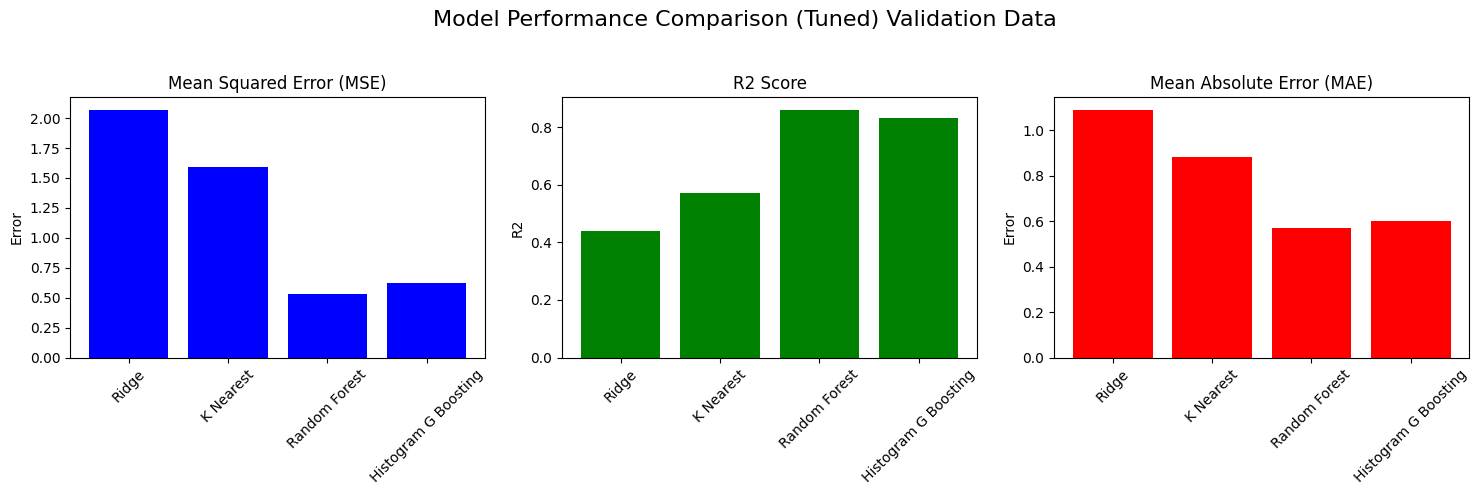

In [ ]:
df_tuned = pd.DataFrame(performance_tuned).T  

metrics_df = df_tuned[['MSE', 'R2', 'MAE']]

display_metrics(metrics_df, 'Model Performance Comparison (Tuned) Validation Data')

The model with the best R2 and MSE is Random Forest. 

Now this models will be tested with testing data.

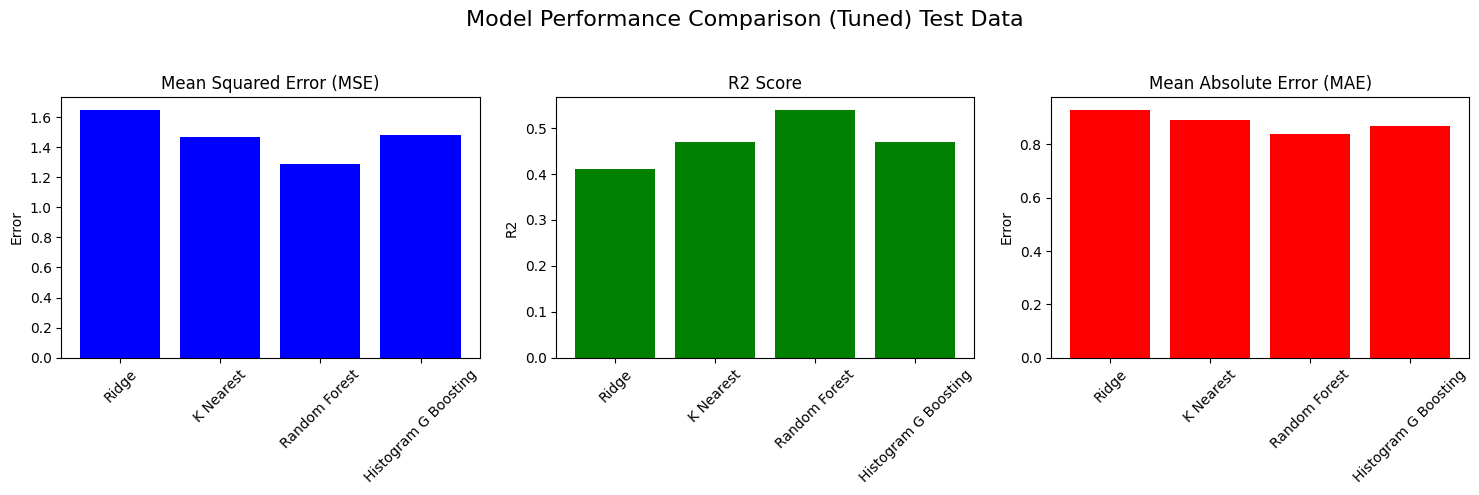

In [68]:
names = ['Ridge', 'K Nearest', 'Random Forest', 'Histogram G Boosting']

performance_test = {}

for name in names:
    y_hat = df_tuned['estimator'][name].predict(X_test)

    # Metrics
    mse, r2, mae = metrics(y_test, y_hat)

    performance_test[name] = {
        'MSE': mse, 
        'R2': r2,
        'MAE': mae
    }

df_tuned_test = pd.DataFrame(performance_test).T

display_metrics(df_tuned_test, 'Model Performance Comparison (Tuned) Test Data')


In [70]:
# Save RF model
model = df_tuned['estimator']['Random Forest']

with open('../models/rf_aquatic_toxicity.pkl', 'wb') as file:
    pickle.dump(model, file)